<h1>Machine Learning Final Project Automated Essay Scoring System</h1>

<p>Assessment in the Education system plays a significant role in judging student
performance. The present evaluation system is through human assessment. As
the number of teachers' student ratio is gradually increasing, the manual
evaluation process becomes complicated. The drawback of manual evaluation
is that it is time-consuming, lacks reliability, and many more. This connection
online examination system evolved as an alternative tool for pen and
paper-based methods.</p>

<h3>Requirements:</h3>

<ol>
    <li>
        Choose any machine learning algorithm to create your own automated essay scoring using the system
        <br/>
    </li>
    <li>
        The quality of an essay is affected by the following four primary dimensions:
        topic relevance, organization and coherence, word usage and sentence
        complexity, and grammar and mechanics. You may use the framework below
        to implement your model but you are allowed to enhance.
    </li>
    <li>
        Use the dataset from the Kaggle ASAP competition. 
        You can download the data from the link below. https://www.kaggle.com/c/asap-aes/data
        <br/>
        <h4>Kaggle ASAP background:</h4>
        <br/>
        The Hewlett Foundation has provided a set of high school student essays
        along with scores generated by human expert graders. The initial data
        was released in 2012 as part of a Kaggle competition to produce an
        automated student assessment algorithm to closely match the human
        scores. Scores are evaluated with the quadratic weighted kappa error
        metric, which measures the agreement between two raters.
        <br/>
        Since then, a few teams have published their attempts to match or
        improve on the original challenge. Initial success was somewhat
        disappointing as the Kappa scores were around 0.5, but improved
        significantly by incorporating modern NLP with neural networks.
        <br/>
    </li>
    <li>
        Project Presentation: 15 minutes only (October 29, 3, 4 and 5)
        <br/>
    </li>
<ol>

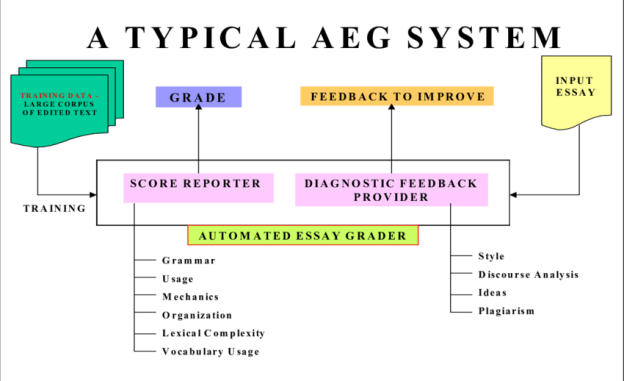

In [1]:
#Initial Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
import re
from matplotlib import pyplot as plt
from gensim.models import Word2Vec

In [2]:
#Necessary Files for NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Declaring Variables
datasetFolder = './data/'
outputFolder = './'

#This implementation of an automated essay grader will utilize the training_set_rel3.tsv file containing all eight essay sets
#The predictor value for this automated essay grader will be domain1_score
#The main metric to gauge the effectiveness of this grader will be kappa score


X = pd.read_csv(os.path.join(datasetFolder, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
data = X
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
#dropping unecessary domain rater columns

In [4]:
#Initial insights for the dataset
X.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [5]:
X.describe()

,essay_id,essay_set,domain1_score
count,12976.000000,12976.000000,12976.000000
mean,10295.395808,4.179485,6.800247
std,6309.074105,2.136913,8.970705
min,1.000000,1.000000,0.000000
25%,4438.750000,2.000000,2.000000
50%,10044.500000,4.000000,3.000000
75%,15681.250000,6.000000,8.000000
max,21633.000000,8.000000,60.000000


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   essay_id       12976 non-null  int64 
 1   essay_set      12976 non-null  int64 
 2   essay          12976 non-null  object
 3   domain1_score  12976 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 405.6+ KB


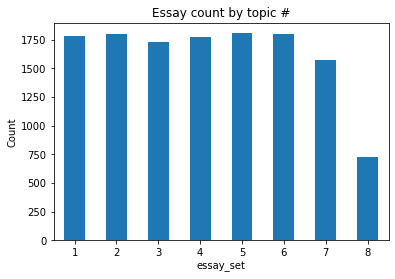

In [7]:
X.groupby('essay_set').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

<AxesSubplot:xlabel='domain1_score', ylabel='count'>

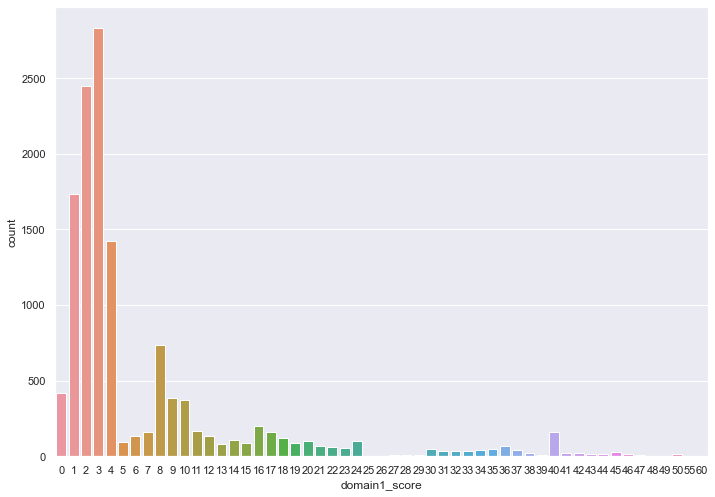

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='domain1_score', data=X)

C:\Users\jorda\miniconda3\envs\myEnv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='domain1_score', ylabel='Density'>

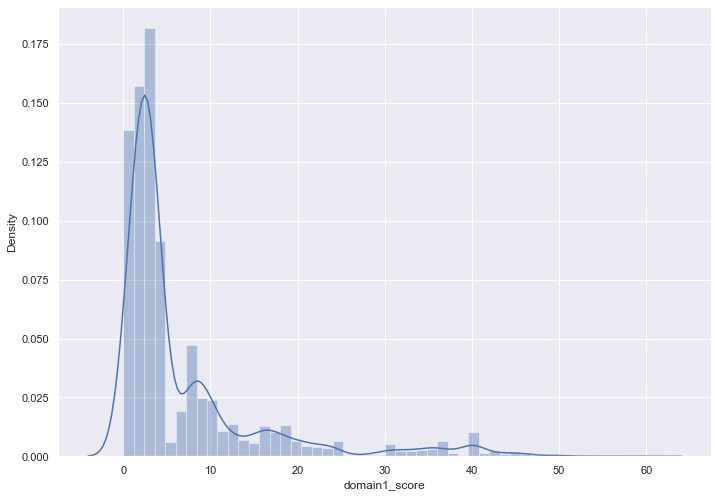

In [9]:
sns.distplot(X['domain1_score'])

In [10]:
# Count characters and words for each essay
X['word_count'] = X['essay'].str.strip().str.split().str.len()

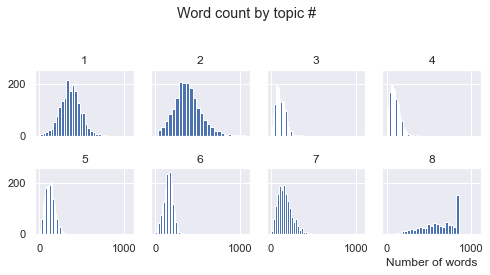

In [11]:
X.hist(column='word_count', by='essay_set', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

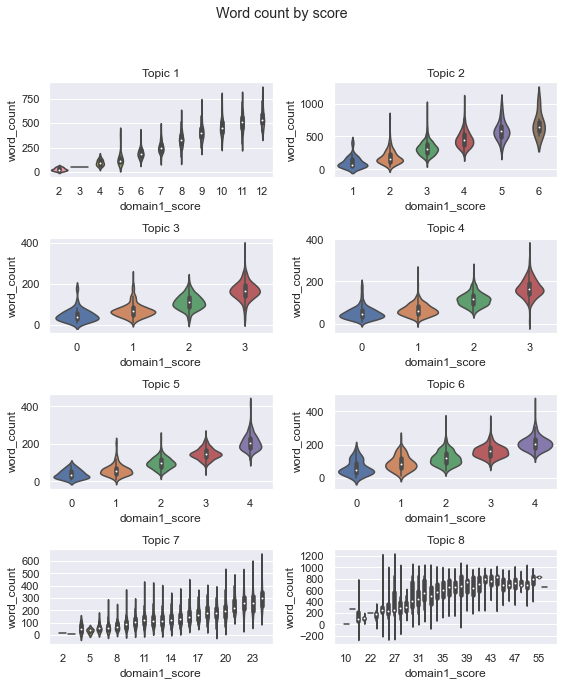

In [12]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='domain1_score', y='word_count', data=X[X['essay_set'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

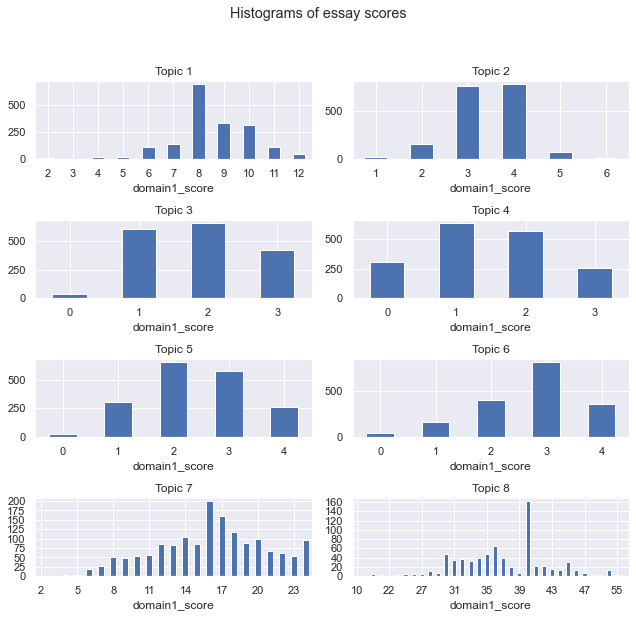

In [13]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        X[X['essay_set'] == topic_number]\
            .groupby('domain1_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<AxesSubplot:title={'center':'domain1_score'}, xlabel='essay_set'>

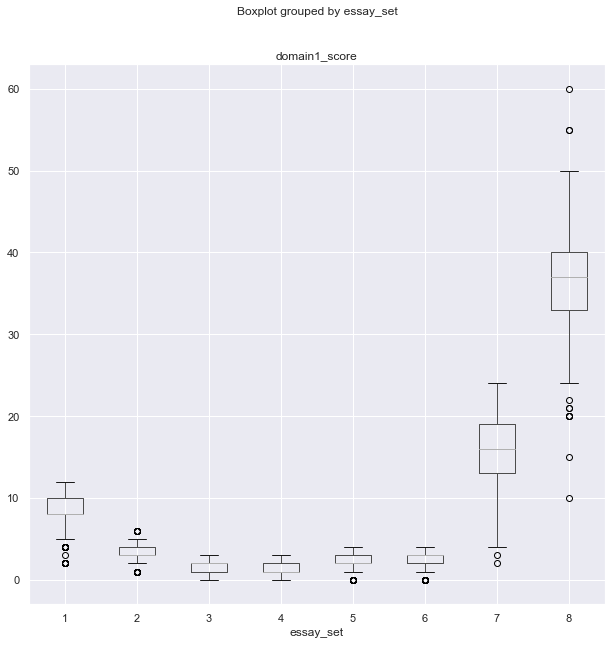

In [14]:
%matplotlib inline
X.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10,10))

<AxesSubplot:xlabel='domain1_score', ylabel='essay_set'>

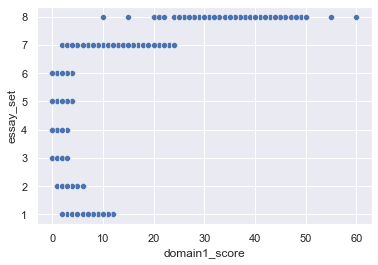

In [15]:
sns.scatterplot(data=X, x="domain1_score", y="essay_set")

It can be seen in this scatter plot that essay sets 8 and 7 have significantly higher domain1_scores (culminated scores between the different human essay graders) than other essay sets.

In [16]:
#converting the essay data into a wordlist while also filtering out unecessary stop words
def convertEssayToWordlist(essay, filterStopwords):
    essay = re.sub("[^a-zA-Z]", " ", essay)
    words = essay.lower().split()
    if filterStopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return (words)

#main tokenization process with some preprocesing
def convertEssayToSentences(essay, filterStopwords):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    uncleanSentences = tokenizer.tokenize(essay.strip())
    sentences = []
    for uncleanSentence in uncleanSentences:
        if len(uncleanSentence) > 0:
            sentences.append(convertEssayToWordlist(uncleanSentence, filterStopwords))
    return sentences

#Feature vectors will be made from words in wordlist
def createFeatureVector(words, model, featureCount):
    featureVectors = np.zeros((featureCount,),dtype="float32")
    wordCount = 0.
    indexToKey = set(model.wv.index_to_key)
    for word in words:
        if word in indexToKey:
            wordCount += 1
            featureVectors = np.add(featureVectors,model.wv[word])        
    featureVectors = np.divide(featureVectors,wordCount)
    return featureVectors

#main function that will allow for word vectors to be usable by the word2Vec model
def averageFeatureVectors(essays, model, featureCount):
    ctr1 = 0
    featureVectors = np.zeros((len(essays),featureCount),dtype="float32")
    for essay in essays:
        featureVectors[ctr1] = createFeatureVector(essay, model, featureCount)
        ctr1 = ctr1 + 1
    return featureVectors

In [17]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def defineModel():
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [18]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score


kFoldSplits = KFold(n_splits=5, shuffle=True)
results = []

count = 1
for trainKfold, testKfold in kFoldSplits.split(X):
    print("\n***Fold Number {}***\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testKfold], X.iloc[trainKfold], y.iloc[testKfold], y.iloc[trainKfold]
    
    essaysTrain = X_train['essay']
    essaysTest = X_test['essay']
    
    sentences = []
    
    #Compiling training essays
    for essay in essaysTrain:
            sentences += convertEssayToSentences(essay, filterStopwords = True)
            
    #Parameters for the model
    featureCount = 300 
    minWordCount = 40
    workerCount = 4
    context = 10
    downsampling = 1e-3

    print("***Starting Model Training***")
    model = Word2Vec(sentences, workers=workerCount, vector_size=featureCount, min_count = minWordCount, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    filteredEssaysTrain = []
    
    #Creating training and testing word vectors
    for essay in essaysTrain:
        filteredEssaysTrain.append(convertEssayToWordlist(essay, filterStopwords=True))
    trainDataVecs = averageFeatureVectors(filteredEssaysTrain, model, featureCount)
    
    filteredEssaysTest = []
    for essay in essaysTest:
        filteredEssaysTest.append(convertEssayToWordlist(essay, filterStopwords=True))
    testDataVecs = averageFeatureVectors(filteredEssaysTest, model, featureCount)
    
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    
    #Reshaping train and test vectors for use in the lstmModel
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
    lstmModel = defineModel()
    lstmModel.fit(trainDataVecs, y_train, batch_size=64, epochs=50)
    y_pred = lstmModel.predict(testDataVecs)
    
    #Rounding off y_pred
    y_pred = np.around(y_pred)
    
    #This is the main evaluation metric (Quadratic mean averaged Kappa)
    #The original attempt for previous AEG systems attempts from other developers was around 0.5
    #Best attempt for the original competition from other developers was around 0.8
    
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    print("=== Kappa Score = {}===".format(result))
    results.append(result)

    count += 1


***Fold Number 1***

***Starting Model Training***


C:\Users\jorda\AppData\Local\Temp\ipykernel_17764\3801135714.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 300)            721200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 5s 10ms/step - loss: 66.0972 - mae: 4.3972
Epoch 2/50
163/163 [==============================] - 2s 10ms/step - loss: 40.8650 - 

C:\Users\jorda\AppData\Local\Temp\ipykernel_17764\3801135714.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 300)            721200    
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 5s 10ms/step - loss: 65.1196 - mae: 4.3911
Epoch 2/50
163/163 [==============================] - 2s 10ms/step - loss: 39.8521 

C:\Users\jorda\AppData\Local\Temp\ipykernel_17764\3801135714.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 300)            721200    
                                                                 
 lstm_5 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 5s 10ms/step - loss: 64.4211 - mae: 4.3744
Epoch 2/50
163/163 [==============================] - 2s 10ms/step - loss: 40.3992 

C:\Users\jorda\AppData\Local\Temp\ipykernel_17764\3801135714.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 300)            721200    
                                                                 
 lstm_7 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 5s 11ms/step - loss: 63.9668 - mae: 4.3320
Epoch 2/50
163/163 [==============================] - 2s 10ms/step - loss: 39.4163 

C:\Users\jorda\AppData\Local\Temp\ipykernel_17764\3801135714.py:33: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 300)            721200    
                                                                 
 lstm_9 (LSTM)               (None, 64)                93440     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
163/163 [==============================] - 5s 11ms/step - loss: 62.1365 - mae: 4.2836
Epoch 2/50
163/163 [==============================] - 2s 11ms/step - loss: 39.3701 

The final kappa score achieved was 0.962